# Nonparametric methods

## Definitions

The terms "parametric" and "nonparametric" have several different meanings. We'll define two, and only focus on one of them:

**Definition 1 (more often used in statistics): this is the version we'll focus on in Data 102**
* A **parametric** method is one where we make specific assumptions about the relationships between data points: for example, in linear regression, we assume that the target variable $y$ is a linear function of the input predictors $x_1, \ldots, x_n$
* A **nonparametric** method is one where we do not make any assumptions about the relationships between the target and predictor variables: instead, we only aim to find the best possible way to make predictions.

According to this definition, linear regression is an example of a parametric method, because we assume (a) a linear relationship between predictors, coefficients, and outcome, and (b) [homoscedastic](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity) normally-distributed noise around the average prediction. On the other hand, $k$-nearest neighbors is an example of a nonparametric method: instead of making any assumptions about the distribution of $x$ or $y$, our prediction is based only on the $k$ nearest neighbors in the training set.

**Definition 2 (more often used in computer science):**
* A **parametric** model is one where the number of parameters (e.g., number of regression coefficients, etc.) is finite, and does not change with the size of the input data.
* A **nonparametric** model is one where the number of parameters is either infinite, or increases with the number of data points.

Before we learn more about nonparametric methods, we'll start by putting them in context against the backdrop of the parametric methods that we've discussed so far in this book (and that you've likely spent a lot of time learning about in your previous statistics and data science courses).

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('DcjHq-5jpko')

## Comparing and Contrasting: Logistic Regression and $k$-Nearest Neighbors

To understand the strengths and weaknesses of the two different approaches for classification, we'll create a simple synthetic dataset and compare two models that we're already familiar with: logistic regression (parametric) and $k$-nearest neighbor classification (nonparametric).

### A Toy Dataset

We'll set up a training dataset with points in a smaller range, and a test dataset with points in a larger range, to help us understand how well the methods generalize.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set()

In [3]:
N_test = 500
N_train = 150

np.random.seed(2024)

# Create a training dataset
X_train = np.random.uniform(-1, 1, [N_train, 2])
y_train = (X_train[:, 0] * X_train[:, 1] > 0).astype(np.int64)

# Create a test dataset
X_test = np.random.uniform(-3, 3, [N_test, 2])
y_test = (X_test[:, 0] * X_test[:, 1] > 0).astype(np.int64)

def draw_results(x, color, plot_title='', ax=None, is_final=True):
    if ax is None:
        f, ax = plt.subplots(1, 1)
    img = ax.scatter(x[:, 0],x[:, 1], c=color, cmap='viridis', alpha=0.7);
    plt.colorbar(img, ax=ax)
    ax.set_title(plot_title)
    ax.axis('equal')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    if is_final:
        plt.tight_layout()

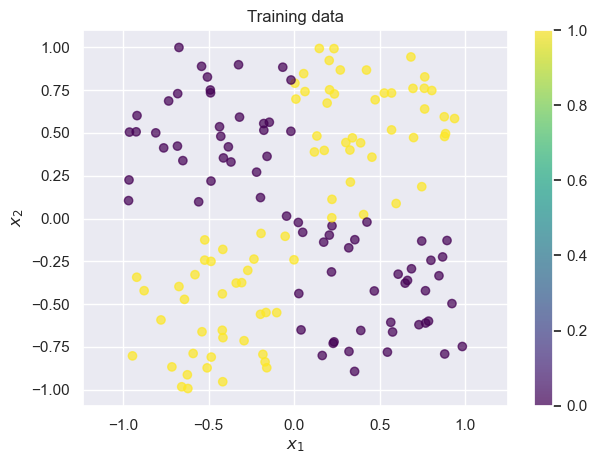

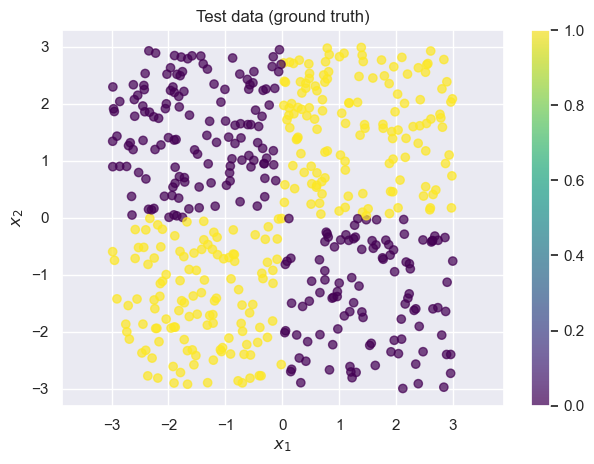

In [4]:
draw_results(X_train, color=y_train, plot_title='Training data')
draw_results(X_test, color=y_test, plot_title='Test data (ground truth)')

We often call datasets like these "toy datasets": they're helpful for illustrating a problem, but they're oversimplified. Real datasets are usually noiser, higher-dimensional, and more complex. Whenever you see an example on toy datasets, it's important to keep in mind that there may be additional complications in your dataset.

### Applying Logistic Regression to the Toy Dataset

Let $p$ be our predicted probability that $y$ is 1 based on $x_1$ and $x_2$. Then logistic regression says:

$$
p = \sigma(\beta_1 x_1 + \beta_2 x_2) \\
\underbrace{\log\left(\frac{p}{1-p}\right)}_{\text{logit: inverse sigmoid}} = \beta_1 x_1 + \beta_2 x_2
$$

Recall that logistic regression tries to find a linear function of $x_1$ and $x_2$ to use as the decision boundary. In this case, that corresponds to drawing a line on the graph above. Unfortunately, for this dataset it's nearly impossible to find any linear decision boundary with an accuracy greater than $50\%$ (i.e., random chance guessing): take a moment to convince yourself this is true by mentally drawing lines on the graph above.

In [5]:
def fit_and_predict_and_draw_results(
    model_class, model_args, model_name, X_train, X_test, y_train, y_test
):
    model = model_class(**model_args)
    model.fit(X_train, y_train)

    # Use the model to predict on the test set
    probs = model.predict_proba(X_test)[:, 1]
    y_hat = (probs > 0.5).astype(np.int64)

    f, axes = plt.subplots(1, 2, figsize=(10, 4.5))
    # Visualize the results
    draw_results(
        X_test, color=probs, ax=axes[0],
        plot_title=f"Predicted P(y=1) ({model_name})",
        is_final=False,
    )

    draw_results(
        X_test, color=y_hat, ax=axes[1],
        plot_title=f"Prediction ({model_name})"
    )

    accuracy = np.mean(y_test == y_hat)
    print(f"Accuracy on test set: {accuracy}")
    return model

Accuracy on test set: 0.626


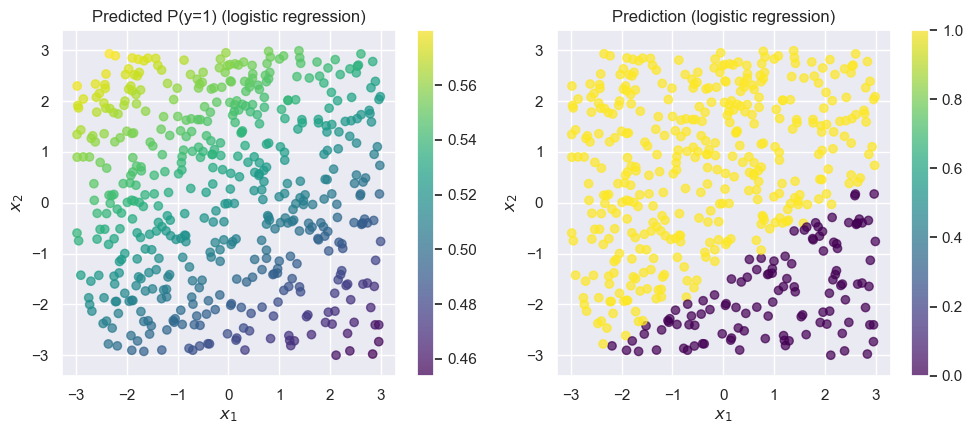

In [6]:
from sklearn.linear_model import LogisticRegression
fit_and_predict_and_draw_results(
    LogisticRegression, dict(penalty=None, solver='lbfgs'), 'logistic regression', 
    X_train, X_test, y_train, y_test
);

As expected, the overall accuracy is close to $0.5$ (which is what we'd get if we predicted completely at random). Logistic regression (without any feature engineering) is a poor choice for this data.


### Applying a $k$-Nearest Neighbor Classifier to the Toy Dataset

Recall that a $k$-nearest neighbor classifier classifies each point based on the label of the $k$ nearest points in the training set.

Accuracy on test set: 0.952


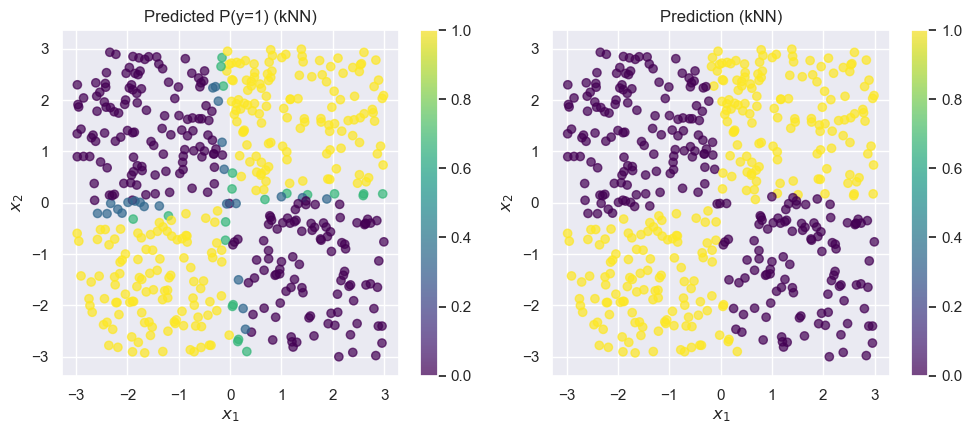

In [7]:
from sklearn.neighbors import KNeighborsClassifier
fit_and_predict_and_draw_results(
    KNeighborsClassifier, dict(n_neighbors=3), 'kNN', 
    X_train, X_test, y_train, y_test
);

The kNN model does much better on this dataset. Best of all, we didn't have to do any feature engineering or parameter tuning: it just worked out of the box.

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('YCfdENsb_YI')

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('AfBgttM7wFc')

### Pros and Cons of Logistic Regression and $k$-Nearest Neighbors

Let's walk through a few of the pros and cons of these two methods. Note that this is far from an exhaustive list!

#### Logistic regression

**PROS**:
* Simple model with only one parameter per input feature (in this case, 2). 
* Parameters can be easily interpreted in a meaningful way: a coefficient $\beta_2$ tells you "If feature $x_2$ increases by a certain amount $a$, the log-odds of $y=1$ increase by $\beta_2 a$."
* The loss function is convex, so there's one best answer and we're guaranteed to get to it.
* Storing/saving the model is cheap, since there are only a few parameters

**CONS**
* Makes an implicit assumption of linear interactions between the inputs (e.g., can't model something like $y = \text{sign}(x_1 x_2)$ as above)
* Modeling complex or nonlinear interactions requires good feature engineering
* Base model is limited in complexity: any complex/nonlinear interactions require lots of feature engineering


#### $k$-Nearest Neighbors

**PROS**:
* Makes no assumptions whatsoever about the data (other than that the training data is a representative sample)
* Easy to implement and understand how it works

**CONS**
* Predictions can be interpreted, but we can't do any more meaningful analysis than "this new point looks like these 5 points I saw before, and 3 of those had $y=1$, so that's why I predicted $y=1$".
* Doesn't work as well in high dimensions (but there are some ways around this)
* Saving the model requires saving all the training points (but there are some ways around this)

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo('SoDiaODgEDQ')

## Decision trees and random forests

### Decision trees

A decision tree is a method for classification and regression that uses a tree-like structure to decide what value to predict for a point. We'll start by taking the entire data. At the root of the tree, we'll split the data based on a particular value of either $x_1$ or $x_2$. We'll then repeat the process for each split, building the tree as deep as we see fit. Our goal in splitting the points is to create as homogeneous a group as possible (in terms of $y$) at the leaves of the tree. Let's look at how we might construct a decision tree for this problem.

1. Our first split is the hardest: we can see that no matter which value of $x_1$ (or $x_2$ we choose, both sides of the split will have half yellow points and half purple points. But, we know that there's a meaningful difference between points where $x_1 > 0$ and points where $x_1 < 0$, so let's choose our first split at $x_1 = 0$. (We could have just as well chosen $x_2 = 0$ too: the choice of $x_1$ is arbitrary even though the choice of threshold value $0$ was not).

2. Let's start by considering one half of the above split: points where $x_1 > 0$, the right half of the plots above. For these points, there's a very natural split at $x_2 = 0$ that gives us completely homogeneous groups: everything above the split is yellow ($y=1$), and everything below is purple ($y=0$). At this point, we're done splitting this branch of the tree: both sub-branches are completely homogeneous.

3. Next, we'll go back to the points where $x_1 < 0$. It turns out that we can use the same split as before, at $x_2 = 0$. In general, decision trees give us the flexibility to make a different split on this side of the tree! It just so happens with this toy dataset that the same sub-split ($x_2 = 0$) works on both sides of our original split ($x_1 = 0$).

And now, we're done. Here's the entire tree:

![Decision tree](tree_small2.jpeg)

To predict the $y$-value for a new point, we start at the root (top), and continue down until we reach a leaf node. This tree ended up very symmetric, but in many problems that won't be the case.


In [11]:
from IPython.display import YouTubeVideo
YouTubeVideo('sjfqHalgC9E')

Here's how it works in scikit-learn:

Accuracy on test set: 0.99


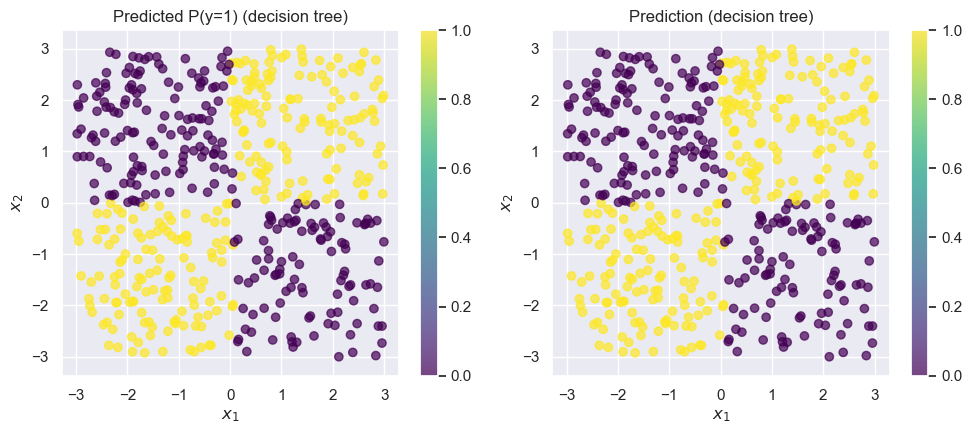

In [12]:
from sklearn.tree import DecisionTreeClassifier
fit_and_predict_and_draw_results(
    DecisionTreeClassifier, {}, 'decision tree', 
    X_train, X_test, y_train, y_test
);

The decision tree is almost perfect.

### Noisy Data: When Decision Trees Fail

Small decision trees work great for problems where the underlying structure is simple. But what if we our data are noisier? Let's randomly flip a few data points ($10\%$ of our training data) and see what happens:

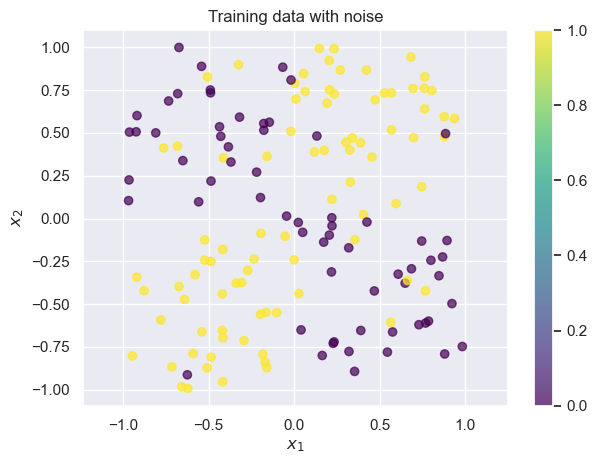

In [13]:
y_train_noisy = y_train.copy()

pts_to_flip = np.random.random(N_train) < 0.1
y_train_noisy[pts_to_flip] = 1 - y_train_noisy[pts_to_flip]

draw_results(X_train, color=y_train_noisy, plot_title='Training data with noise')

Now there are a small handful of points where the training label is wrong. Let's try fitting a decision tree again: we'll train on the noisy data, but we'll test on the good data, so that we can evaluate whether the model learns the true pattern despite the noise.

Accuracy on test set: 0.746


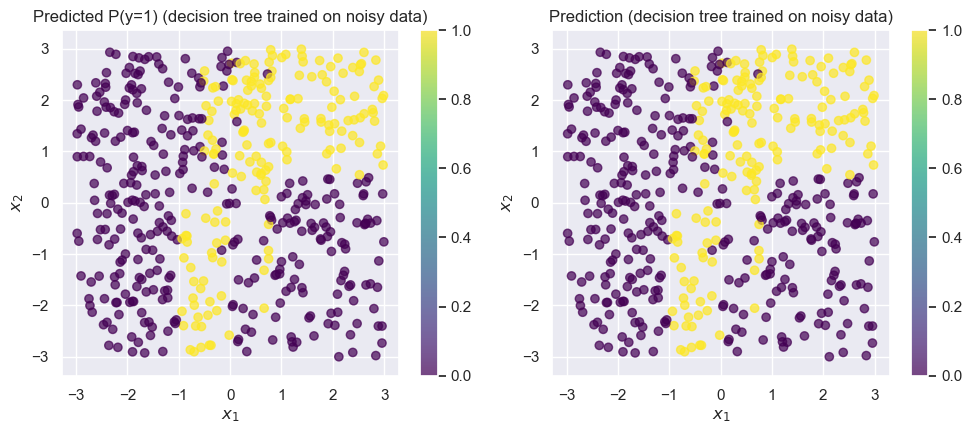

In [14]:
# Note that we use the noisy training data from above by passing in `y_train_noisy`
fit_and_predict_and_draw_results(
    DecisionTreeClassifier, {}, 'decision tree trained on noisy data', 
    X_train, X_test, y_train_noisy, y_test
);

Changing just $10\%$ of the points completely wrecked the tree! Our accuracy dropped to around $75\%$. While this is a toy dataset, it's not uncommon in real-world datasets to see $10\%$ of the data be corrupted by noise. 

## Random Forests

We'll solve this problem by using a random forest instead of a decision tree. Random forests use are built using decision trees, and apply two key ideas: **bootstrap aggregation, or bagging** and **random feature selection**.

### Bootstrap Aggregation (Bagging)

We'll fix this by using many trees instead of just one: this is known as an **ensemble**. We'll train each tree separately, and then combine their decisions when making a prediction. Ideally, we would get a fresh dataset for each one, and train each tree separately. outUnfortunately, we usually can't get that many separate datasets, and if we divide our training dataset into 100, we're losing out on valuable data we could use to train each of the trees.

But, we've already seen a way around this: we can use the bootstrap! Notice that here, we're using bootstrap for a completely different purpose than before: instead of using it to quantify uncertainty, we're using it to mitigate the effect of noise in our data. This is called **Bootstrap AGGregation**, or **bagging**. 

### Random feature selection

The second big idea is **random feature selection**. In this toy example, we've been working with 2 features $x_1$ and $x_2$. But in many real problems, you may have hundreds or even thousands of features. Using the algorithm we have above, for a decision tree to properly deal with that many features, it would have to be extremely deep (since we'd need one node/split for every feature that's relevant). Since we're using multiple trees, we don't need each tree to be perfect. So, we'll just choose a subset of the features for each tree.

In practice, for $K$ features, people use $K/3$ features per tree for **regression** and $\sqrt{K}$ features per tree for **classification**.

So, here's how the random forest algorithm works: we train a large number of trees independently, where each one is trained on a bootstrap sample of the data and on a smaller number of features. 

In [15]:
X_train.shape

(150, 2)

Accuracy on test set: 0.958


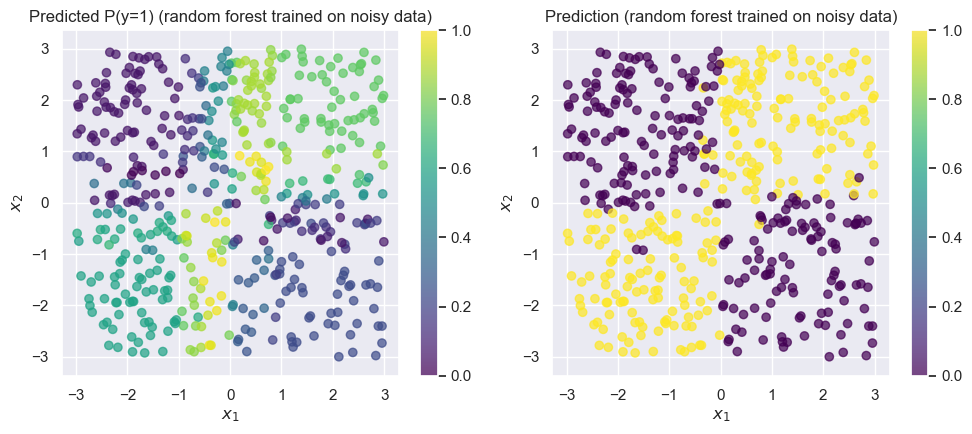

In [16]:
from sklearn.ensemble import RandomForestClassifier
fit_and_predict_and_draw_results(
    RandomForestClassifier, {}, 'random forest trained on noisy data', 
    X_train, X_test, y_train_noisy, y_test
);

The random forest achieves $95\%$ training accuracy. Remember that the labels in our training data was only $90\%$ accurate, so $95\%$ here is very impressive!

There are a lot of important details that we haven't covered here. Some of these (e.g., choosing the number of trees) are hyperparameters that we have to decide on using something like cross-validation, while others (e.g., how we decide the best place to split at each iteration while building a tree) are an important part of the algorithm that's beyond what we'll cover in this class. 

In [17]:
from IPython.display import YouTubeVideo
YouTubeVideo('CZObqvT_gWU')

## Interpretability

How do we interpret the models we've developed? Let's look at the results we already computed before, but now we'll also interpret the models themselves.

### Interpreting logistic regression

In logistic regression (or any GLM), the main way we interpret the model is by looking at the coefficients. As discussed in previous sections, we can interpret a coefficient $\beta_i$ by saying "if $x_i$ increases by $t$, then $LinkFunction(y)$ increases by $\beta_i \times t$. In the case of logistic regression, this corresopnds to the log-odds increasing by $t \times \beta_i$. So, let's look at the coefficients for our logistic regression model, by using the `.coef_` attribute of `sklearn` linear models:

Accuracy on test set: 0.626
Coefficients: [[-0.03490349  0.05527346]]


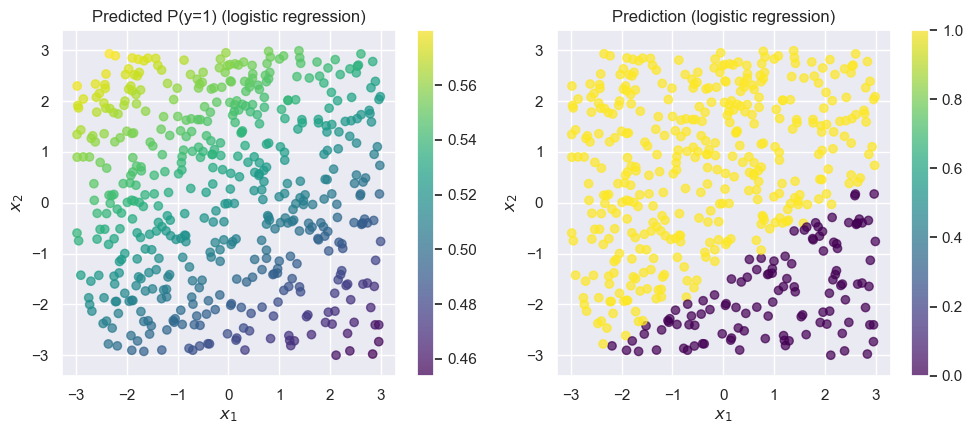

In [18]:
logistic_model = fit_and_predict_and_draw_results(
    LogisticRegression, dict(penalty=None, solver='lbfgs'), 'logistic regression', 
    X_train, X_test, y_train, y_test
);
print('Coefficients:', logistic_model.coef_)

This tells us that for an increase of 1 in $x_1$, the log-odds decreases by $0.03$. Unfortunately, this interpretion is meaningless, because the model does not accurately reflect the patterns in the data! This is an important lesson: the interpretation of a model is, at best, only as good as the model itself.



### Interpreting logistic regression with feature engineering

Up until now, we've painted logistic regression as being a poor choice for this problem. But in reality, linear models are more than capable of making predictions when there are nonlinear patterns: we just need to use **feature engineering** to define good features.

For this particular problem, the feature $x_1 \times x_2$ would be particularly useful, since it captures the nonlinear interaction that's most important to the problem. We'll add this as a third column in our matrix of predictors, and then try logistic regression:

Accuracy on test set: 0.996


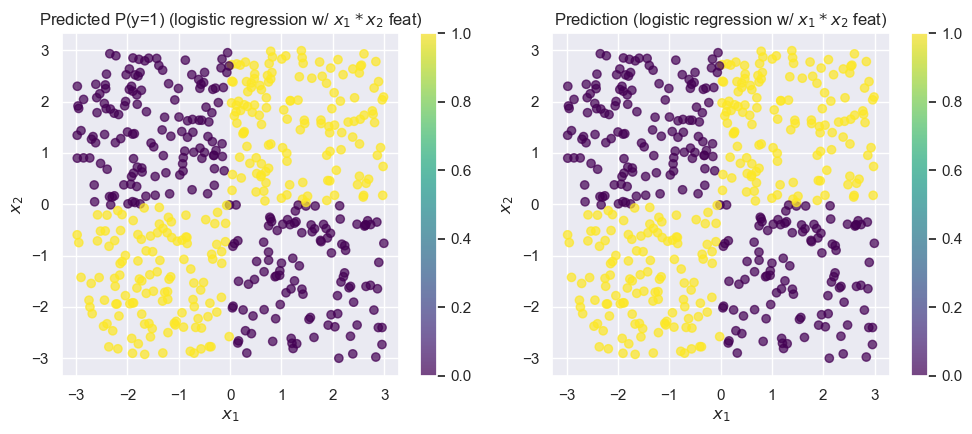

In [20]:
from sklearn.linear_model import LogisticRegression
# Create a new feature: x1 * x2
def add_mult_feature(X):
    """Returns an array like X, but with a new feature that's X1 * X2"""
    new_feature = X[:, 0] * X[:, 1]
    return np.hstack([X, new_feature[:, None]])

# Define new versions of X with the extra feature
X_train_feat = add_mult_feature(X_train)
X_test_feat = add_mult_feature(X_test)

logistic_model_feats = fit_and_predict_and_draw_results(
    LogisticRegression, dict(penalty=None, solver='lbfgs'), 'logistic regression w/ $x_1 * x_2$ feat', 
    X_train_feat, X_test_feat, y_train, y_test
);

Unsurprisingly, this model does *much* better! Now that we've resolved our issues with the model's accuracy, let's see if we can interpret the coefficients:

In [21]:
logistic_model_feats.coef_

array([[  277.36746859,   -56.97829336, 19397.32580951]])

This tells us that increases in $x_1$ or $x_2$ by themselves result in relatively small changes in the log-odds. But, the third feature, $x_1 \times x_2$, has a coefficient that's three orders of magnitude larger! We can interpret this as saying that an increase in $x_1 \times x_2$ leads to very large increases in the log-odds, which is exactly the pattern we observe when looking at the data: positive values of $x_1 \times x_2$ are labeled with "1", while negative values are labeled with "0".

### Explaining Predictions from k-Nearest Neighbors

When looking at a prediction from a kNN model, it's much harder to draw the same broad conclusions we did above by using the GLM coefficients. To make general statements about what the kNN classifier will do, we'd have to be able to understand all the training data points. In this simple two-dimensional example, this might be feasible by looking at the decision boundaries. But, in higher dimensions, this is much more difficult! Because of this, we say that kNN classifiers are less easily **interpretable**.

Instead of trying to interpret the model holistically, we'll focus only on individual predictions. For any individual prediction made by a kNN classifier, we can always provide the $k$ nearest neighbors in the training set that contributed to that decision, along with the labels for each. This can often provide important insights into why a prediction was made in a particular way. We'll call these **explanations** for each individual prediction.

Accuracy on test set: 0.952


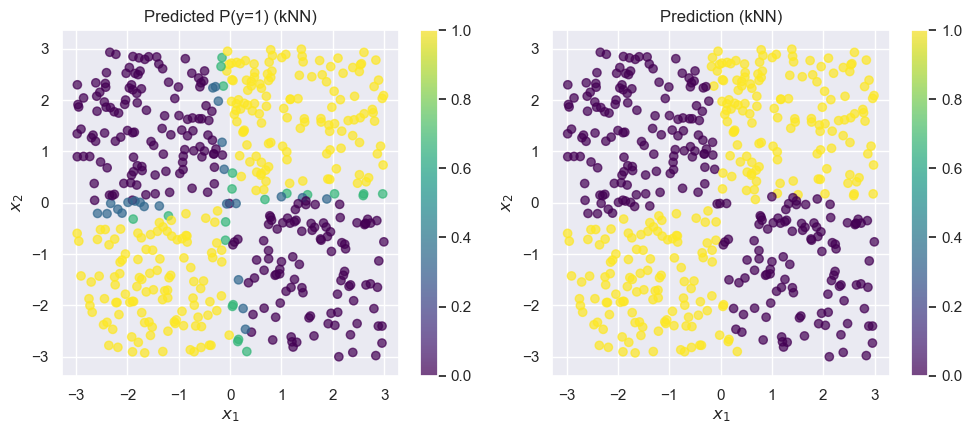

In [22]:
from sklearn.neighbors import KNeighborsClassifier
fit_and_predict_and_draw_results(
    KNeighborsClassifier, dict(n_neighbors=3), 'kNN', 
    X_train, X_test, y_train, y_test
);

Consider the misclassified point around $(0.2, -2.9)$. If we ask why this point has been misclassified, the answer is in the training set.

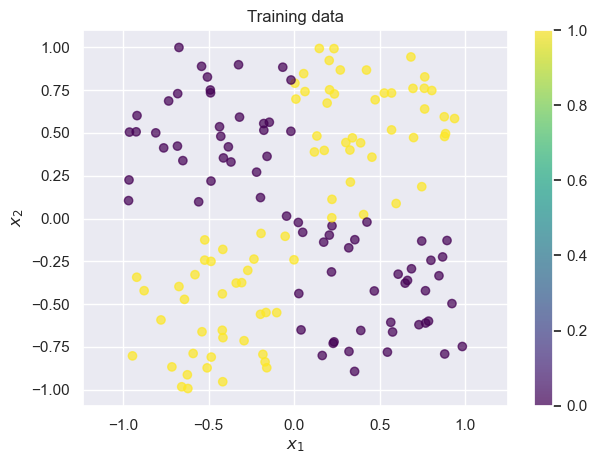

In [23]:
draw_results(X_train, color=y_train, plot_title='Training data')

We can see that the bottom-left portion of quadrant IV is rather sparse in our training datsaset. If we consider the point at $(0.2, -2.9)$, we can see that it's likely to be equidistant to the "1" (yellow) points toward the bottom of quadrant III! This is the cause of the misclassification.

So, for any prediction obtained from a k-nearest neighbors classifier, we can obtain an **explanation**, even if the model itself isn't as amenable to **interpretation**.

### Interpeting a Decision Tree

Are decision trees interpretable? We'll see that the answer depends on the size of the tree. We'll start with the tree trained on the clean (non-noisy) dataset:

Accuracy on test set: 0.99


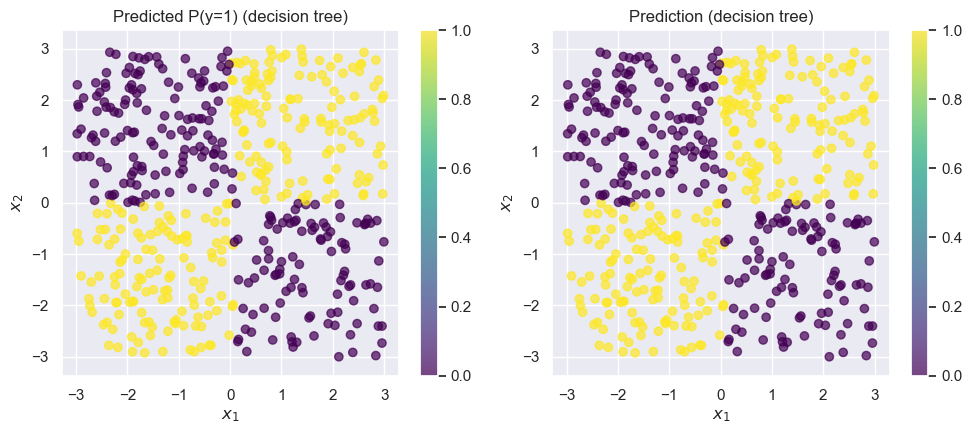

In [24]:
from sklearn.tree import DecisionTreeClassifier
tree_model = fit_and_predict_and_draw_results(
    DecisionTreeClassifier, {}, 'decision tree', 
    X_train, X_test, y_train, y_test
);

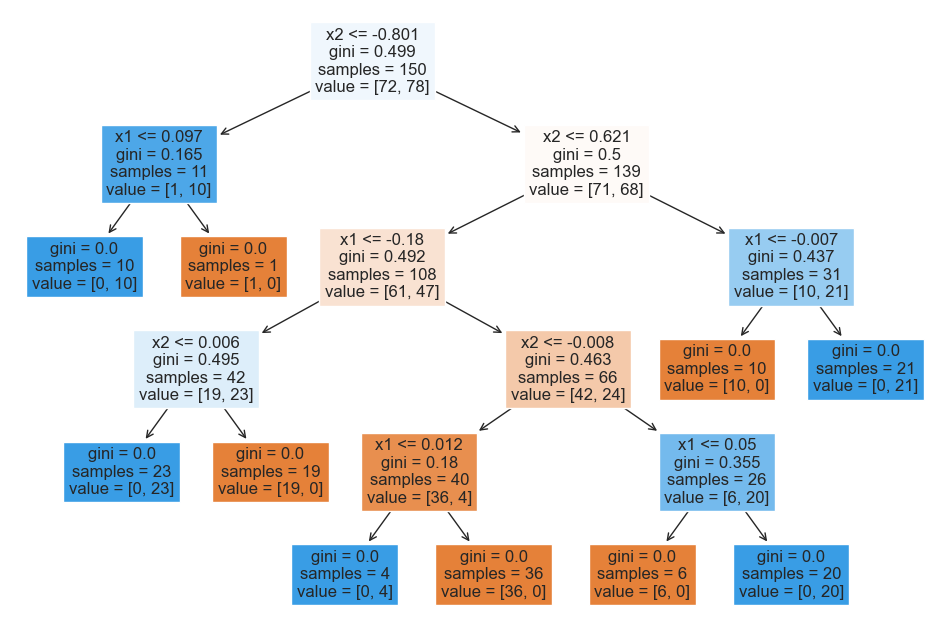

In [25]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(tree_model, fontsize=12, filled=True, feature_names=['x1', 'x2']);

While the top of the tree is somewhat counterintuitive due to the arbitrary nature of the initial split, we can see that the lower layers are easy to interpret: we split at $x_1$ and $x_2$ values close to 0.

What about the tree that was trained on the noisy version of the data?

Accuracy on test set: 0.746


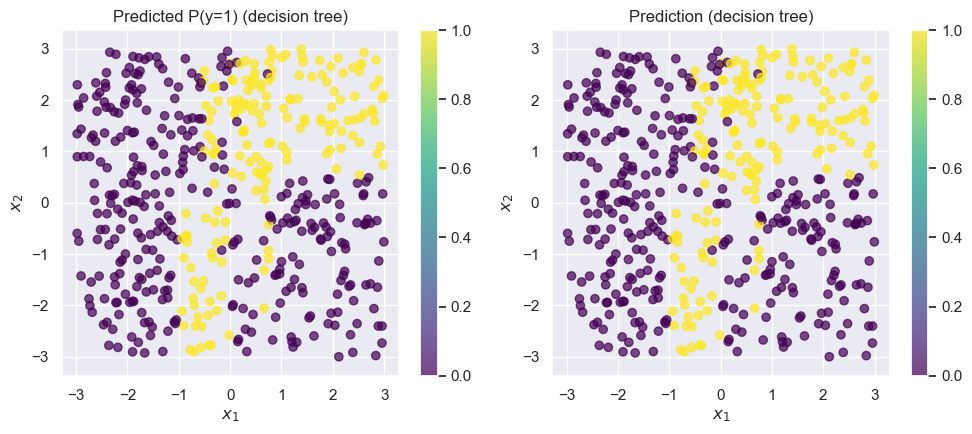

In [26]:
from sklearn.tree import DecisionTreeClassifier
tree_model_from_noisy_y = fit_and_predict_and_draw_results(
    DecisionTreeClassifier, {}, 'decision tree', 
    X_train, X_test, y_train_noisy, y_test
);

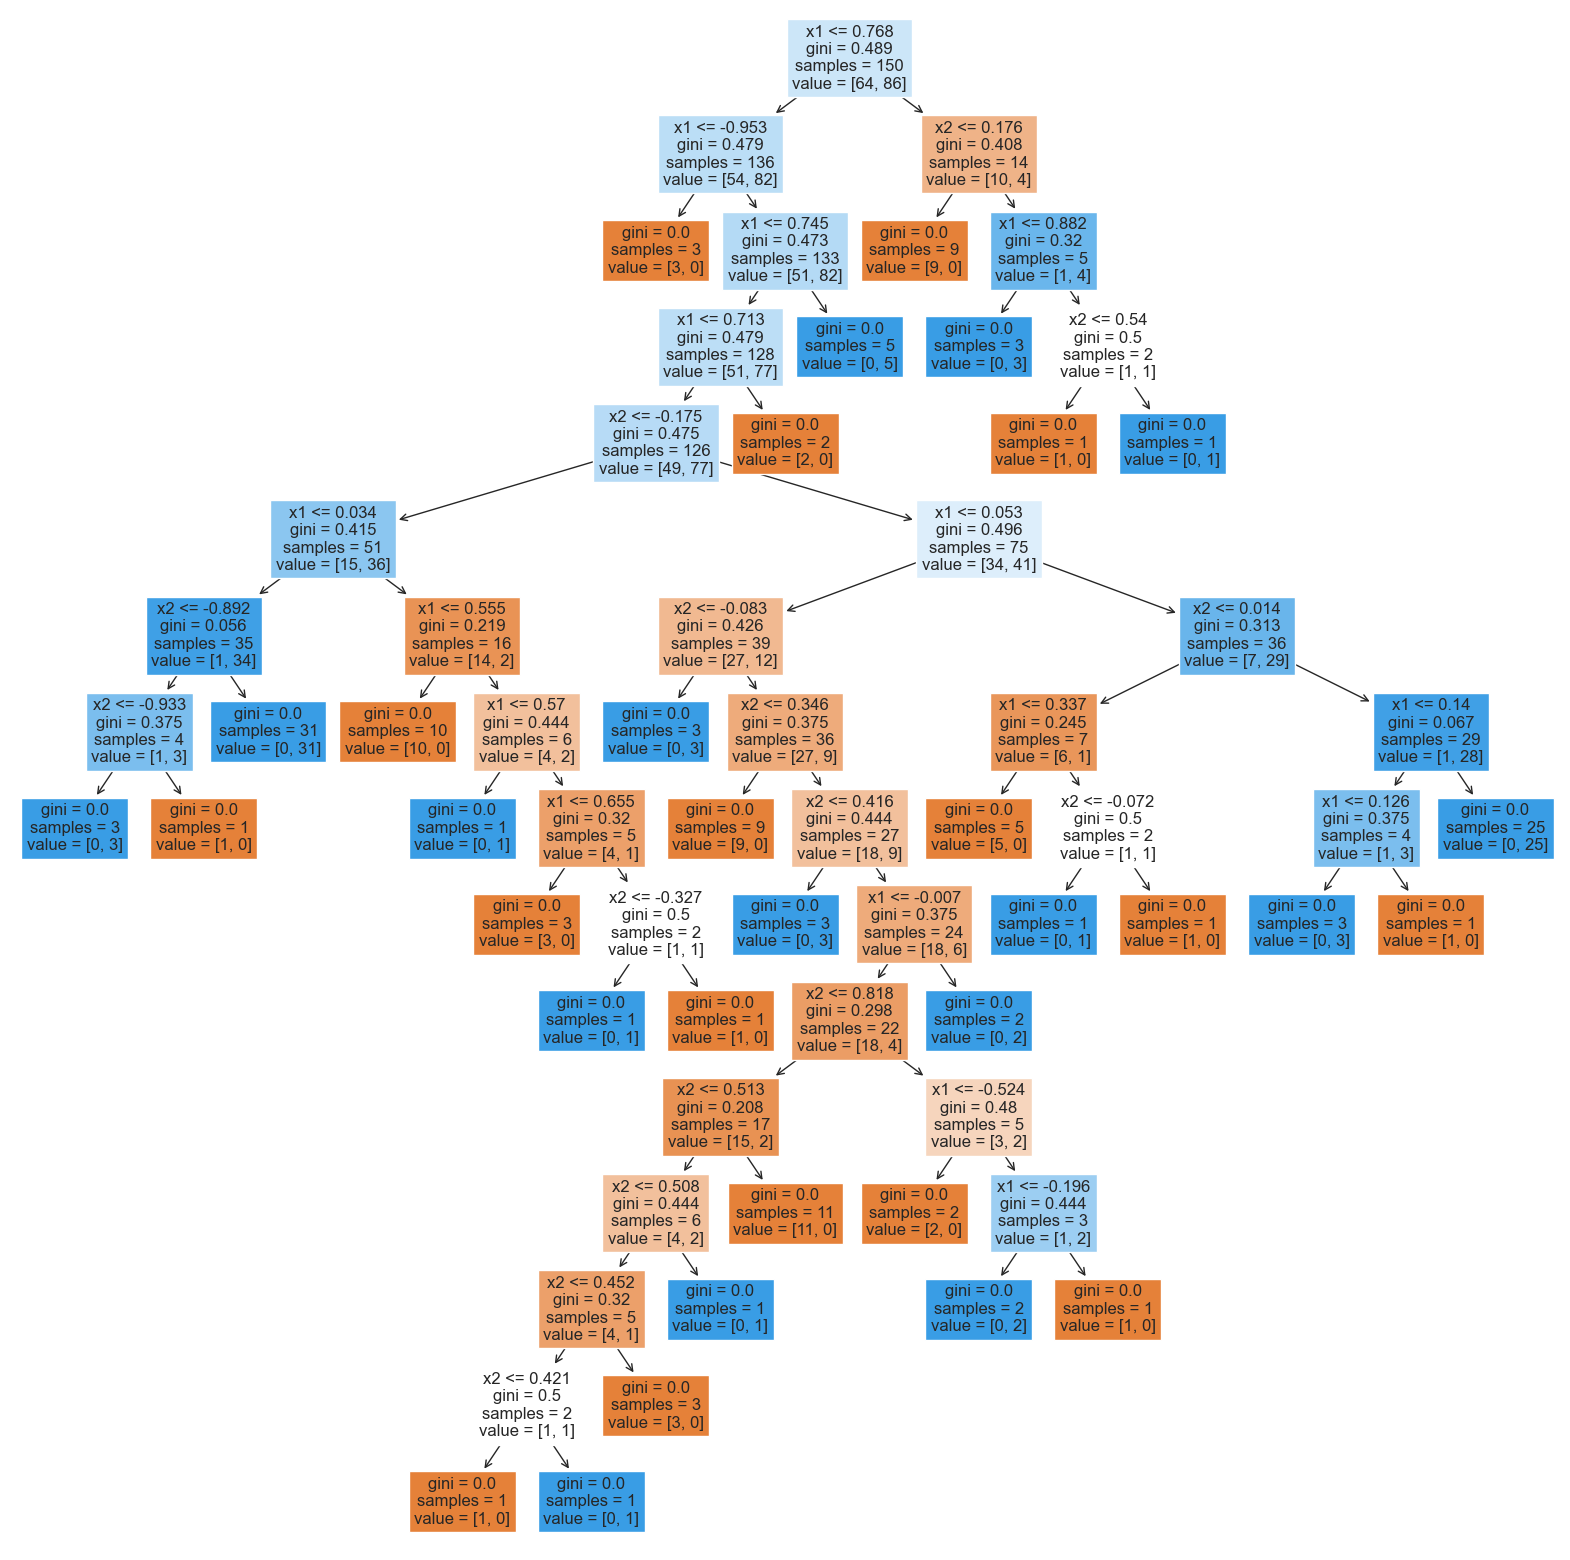

In [27]:
plt.figure(figsize=(20, 20))
plot_tree(
    tree_model_from_noisy_y,
    fontsize=12, 
    filled=True, 
    feature_names=['x1', 'x2']
);

This tree is **much** more difficult to interpret! Tracing any individual prediction may require us to go down up to 15 levels deep: and, this is just for a simple two-dimensional toy dataset! In real-world datasets in higher dimensions, trees can be even deeper.

### Interpreting Random Forests

Unfortunately, random forests are even worse: instead of interpreting one potentially large tree, we must simultaneously interpret hundreds of them! This is a critical weakness of random forests: while they often achieve excellent accuracy, they are often difficult to interpret.

In [28]:
from IPython.display import YouTubeVideo
YouTubeVideo('5vrzxIyGU4w')

### Explanations for Black-Box Models

*Coming soon*

In [29]:
from IPython.display import YouTubeVideo
YouTubeVideo('1odBKmKSPG0')